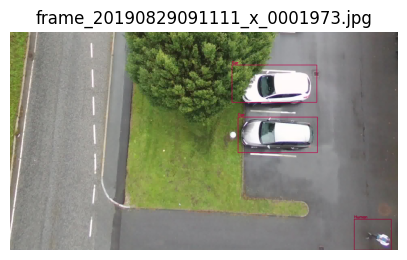

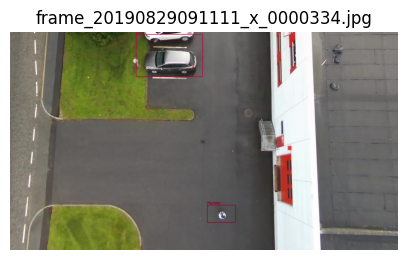

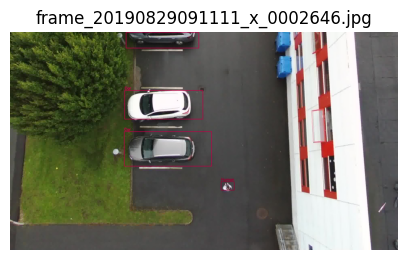

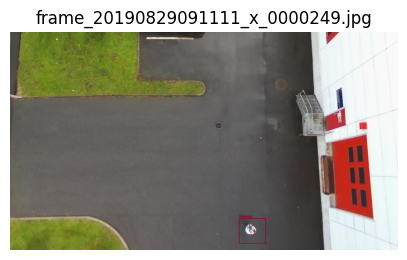

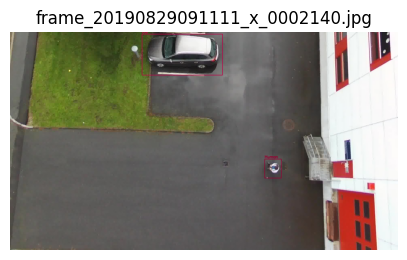

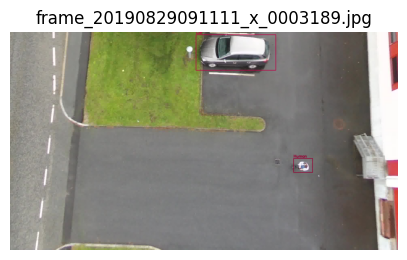

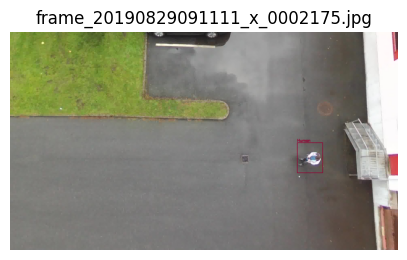

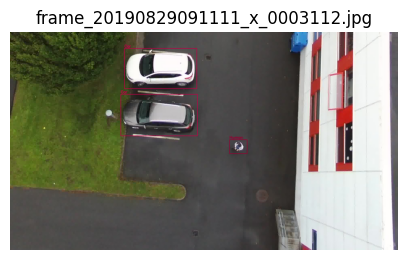

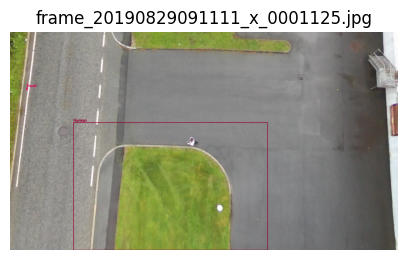

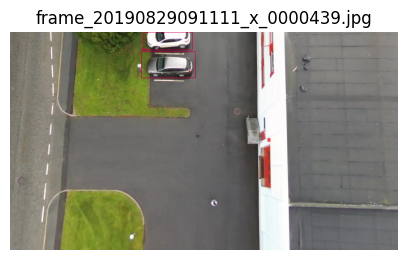

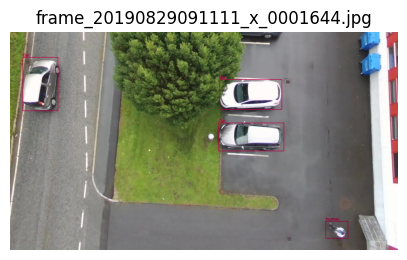

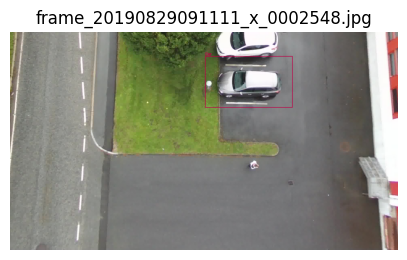

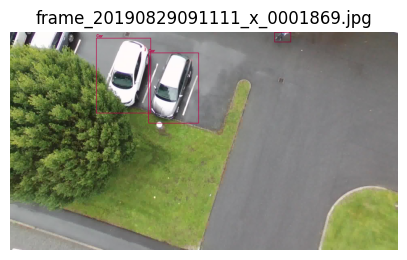

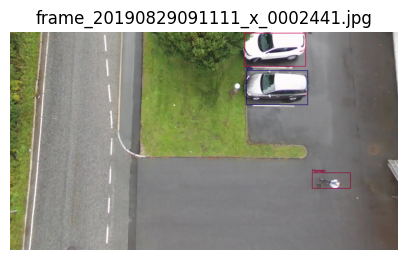

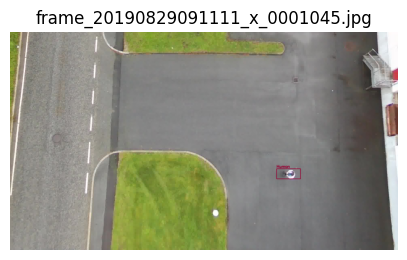

In [1]:
# Visualization of data
import json
import os
import cv2
import matplotlib.pyplot as plt

ANNOTATIONS_PATH = "auair2019/annotations.json"
IMAGES_DIR = "auair2019/images"
CATEGORY_NAMES = ["Human", "Car", "Truck", "Van", "Motorbike", "Bicycle", "Bus", "Trailer"]
COLOR_MAP = {
    i: (int(50 + i * 20) % 255, int(100 + i * 30) % 1, int(150 + i * 40) % 255)
    for i in range(len(CATEGORY_NAMES))
}

def draw_boxes_cv2(image_path, boxes):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    for box in boxes:
        x, y, w, h = int(box["left"]), int(box["top"]), int(box["width"]), int(box["height"])
        class_id = box["class"]
        label = CATEGORY_NAMES[class_id] if 0 <= class_id < len(CATEGORY_NAMES) else "Unknown"
        color = COLOR_MAP.get(class_id, (0, 255, 0))
        
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def visualize_cv2(json_path, images_dir, max_images=5):
    with open(json_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"]
    count = 0

    for item in annotations:
        if count >= max_images:
            break

        filename = item["image_name"]
        image_path = os.path.join(images_dir, filename)

        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            continue

        image = draw_boxes_cv2(image_path, item["bbox"])
        plt.figure(figsize=(5, 3))
        plt.imshow(image)
        plt.axis("off")
        plt.title(filename)
        plt.show()
        count += 1

visualize_cv2(ANNOTATIONS_PATH, IMAGES_DIR, max_images=15)

In [2]:
# EDA and Validation of BBoxes
from tqdm import tqdm

DEFAULT_WIDTH = 1920
DEFAULT_HEIGHT = 1080
INPUT_JSON = "auair2019/annotations.json"
OUTPUT_JSON_ALL = "auair2019/annotations_formatted.json"
OUTPUT_JSON_VALID = "auair2019/annotations_formatted_valid.json"

CATEGORY_NAMES = ["Human", "Car", "Truck", "Van", "Motorbike", "Bicycle", "Bus", "Trailer"]
CATEGORY_MAPPING = [{"id": i + 1, "name": name.lower()} for i, name in enumerate(CATEGORY_NAMES)]

class BBoxStatistics:
    def __init__(self):
        self.invalid_boxes = []
        self.total_boxes = 0
        self.invalid_count = 0
        self.images_with_invalid_boxes = set()
        self.images_with_no_boxes = []
        self.category_counts_all = {name: 0 for name in CATEGORY_NAMES}
        self.category_counts_valid = {name: 0 for name in CATEGORY_NAMES}

    def invalid_box(self, filename: str, x: float, y: float, w: float, h: float, class_id: int, reason: str):
        self.invalid_boxes.append({
            'filename': filename,
            'bbox': {'x': x, 'y': y, 'w': w, 'h': h},
            'class': CATEGORY_NAMES[class_id] if class_id < len(CATEGORY_NAMES) else 'unknown',
            'reason': reason
        })
        self.invalid_count += 1
        self.images_with_invalid_boxes.add(filename)

    def empty_image(self, filename: str):
        self.images_with_no_boxes.append(filename)

    def add_category_count(self, class_id: int, is_valid: bool = True):
        if 0 <= class_id < len(CATEGORY_NAMES):
            category = CATEGORY_NAMES[class_id]
            if not is_valid:
                self.category_counts_all[category] += 1
            elif is_valid:
                self.category_counts_valid[category] += 1

    def print_report(self):
        print("\nSummary:")
        print(f"Total bounding boxes processed: {self.total_boxes}")
        print(f"Total invalid bounding boxes: {self.invalid_count}")
        print(f"Number of images with invalid boxes: {len(self.images_with_invalid_boxes)}")
        print(f"Number of images with no boxes after filtering invalid ones: {len(self.images_with_no_boxes)}")
        print("\nCategory Statistics:")
        print("Category     | All Annotations| Valid Annotations| % Valid")
        print("-" * 60)
        for category in CATEGORY_NAMES:
            all_count = self.category_counts_all[category]
            valid_count = self.category_counts_valid[category]
            percent_valid = (valid_count / all_count * 100) if all_count > 0 else 0
            print(f"{category:<12} | {all_count:>14} | {valid_count:>16} | {percent_valid:>6.2f}%")

        print("\nInvalid Box Listing:")
        for i, invalid in enumerate(self.invalid_boxes, 1):
            print(f"\n{i}. Image: {invalid['filename']}")
            print(f"Class: {invalid['class']}")
            bbox = invalid['bbox']
            print(f"Values: x={bbox['x']}, y={bbox['y']}, w={bbox['w']}, h={bbox['h']}")
            print(f"Reason: {invalid['reason']}")

        if self.images_with_no_boxes:
            print("\nImages that lost all boxes after filtering invalid ones:")
            for i, filename in enumerate(self.images_with_no_boxes, 1):
                print(f"{i}. {filename}")

def validate_bbox(x: float, y: float, w: float, h: float, filename: str, class_id: int, stats: BBoxStatistics, image_width: int, image_height: int) -> bool:
    
    # Avoid non zero values
    if x < 0 or y < 0 or w <= 0 or h <= 0:
        stats.invalid_box(filename, x, y, w, h, class_id, "Negative or zero dimension")
        return False

    # Avoid out of image bounds
    if x + w > image_width or y + h > image_height:
        stats.invalid_box(filename, x, y, w, h, class_id, "Bounding box out of image bounds")
        return False
    
    # Avoid extreme aspect ratios
    aspect_ratio = w / h if h > 0 else 0
    if aspect_ratio > 10 or aspect_ratio < 0.1:
        stats.invalid_box(filename, x, y, w, h, class_id, "Extreme aspect ratio")
        return False

    return True

def convert(input_json_path: str, output_json_all: str, output_json_valid: str) -> None:
    
    with open(input_json_path, "r") as f:
            raw_data = json.load(f)

    if "annotations" not in raw_data:
        raise ValueError("Input JSON missing 'annotations' key")

    all_bbox = {
        "images": [],
        "annotations": [],
        "categories": CATEGORY_MAPPING
    }
    
    valid_box = {
        "images": [],
        "annotations": [],
        "categories": CATEGORY_MAPPING
    }

    image_id = 1
    ann_id_all = 1
    ann_id_valid = 1
    total_images = 0
    total_annotations_all = 0
    total_annotations_valid = 0
    
    stats = BBoxStatistics()

    for item in tqdm(raw_data["annotations"]):
        filename = item["image_name"]
        width = int(item.get("image_width", DEFAULT_WIDTH))
        height = int(item.get("image_height", DEFAULT_HEIGHT))

        image_entry = {
            "id": image_id,
            "file_name": filename,
            "width": width,
            "height": height
        }
        
        all_bbox["images"].append(image_entry.copy())
        has_valid_boxes = False

        valid_boxes_count = 0
        for box in item["bbox"]:
            stats.total_boxes += 1
            x = box["left"]
            y = box["top"]
            w = box["width"]
            h = box["height"]
            class_id = box["class"]

            stats.add_category_count(class_id, is_valid=False)

            annotation_all = {
                "id": ann_id_all,
                "image_id": image_id,
                "category_id": class_id + 1,
                "bbox": [x, y, w, h],
                "area": w * h,
                "iscrowd": 0
            }
            all_bbox["annotations"].append(annotation_all)
            ann_id_all += 1
            total_annotations_all += 1

            if validate_bbox(x, y, w, h, filename, class_id, stats, width, height):
                valid_boxes_count += 1
                stats.add_category_count(class_id, is_valid=True)
                
                annotation_valid = {
                    "id": ann_id_valid,
                    "image_id": image_id,
                    "category_id": class_id + 1,
                    "bbox": [x, y, w, h],
                    "area": w * h,
                    "iscrowd": 0
                }
                valid_box["annotations"].append(annotation_valid)
                ann_id_valid += 1
                total_annotations_valid += 1
                has_valid_boxes = True

        if item["bbox"] and valid_boxes_count == 0:
            stats.empty_image(filename)

        if has_valid_boxes:
            valid_box["images"].append(image_entry)

        image_id += 1
        total_images += 1

    for output_path in [output_json_all, output_json_valid]:
        output_dir = os.path.dirname(output_path)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

    # Save output files
    with open(output_json_all, "w") as f:
        json.dump(all_bbox, f)

    with open(output_json_valid, "w") as f:
        json.dump(valid_box, f)

    print(f"All annotations saved to: {output_json_all}")
    print(f"Valid annotations saved to: {output_json_valid}")
    print(f"\nProcessed {total_images} images with:")
    print(f"- All annotations: {total_annotations_all}")
    print(f"- Valid annotations: {total_annotations_valid}")
    
    stats.print_report()

if __name__ == "__main__":
    convert(INPUT_JSON, OUTPUT_JSON_ALL, OUTPUT_JSON_VALID)

100%|██████████| 32823/32823 [00:00<00:00, 40827.80it/s]


All annotations saved to: auair2019/annotations_formatted.json
Valid annotations saved to: auair2019/annotations_formatted_valid.json

Processed 32823 images with:
- All annotations: 132031
- Valid annotations: 131825

Summary:
Total bounding boxes processed: 132031
Total invalid bounding boxes: 206
Number of images with invalid boxes: 186
Number of images with no boxes after filtering invalid ones: 9

Category Statistics:
Category     | All Annotations| Valid Annotations| % Valid
------------------------------------------------------------
Human        |           5158 |             5144 |  99.73%
Car          |         102619 |           102466 |  99.85%
Truck        |           9545 |             9531 |  99.85%
Van          |           9995 |             9985 |  99.90%
Motorbike    |            319 |              318 |  99.69%
Bicycle      |           1128 |             1126 |  99.82%
Bus          |            729 |              726 |  99.59%
Trailer      |           2538 |         

In [3]:
# Check for new format
def sample_file(path, num_anns=10):
    with open(path, "r") as f:
        file = json.load(f)

    print("Sample Image Entry")
    print(json.dumps(file["images"][0]))

    print("\nSample Annotations")
    for annotation in file["annotations"][:num_anns]:
        print(json.dumps(annotation))

    print("\nCategories")
    for category in file["categories"]:
        print(f"category_id: {category['id']}, name: {category['name']}")

sample_file(OUTPUT_JSON_VALID)

Sample Image Entry
{"id": 1, "file_name": "frame_20190829091111_x_0001973.jpg", "width": 1920, "height": 1080}

Sample Annotations
{"id": 1, "image_id": 1, "category_id": 2, "bbox": [1098, 163, 420, 185], "area": 77700, "iscrowd": 0}
{"id": 2, "image_id": 1, "category_id": 2, "bbox": [1128, 421, 393, 176], "area": 69168, "iscrowd": 0}
{"id": 3, "image_id": 1, "category_id": 1, "bbox": [1703, 927, 183, 153], "area": 27999, "iscrowd": 0}
{"id": 4, "image_id": 2, "category_id": 1, "bbox": [976, 857, 139, 86], "area": 11954, "iscrowd": 0}
{"id": 5, "image_id": 2, "category_id": 2, "bbox": [624, 11, 328, 210], "area": 68880, "iscrowd": 0}
{"id": 6, "image_id": 3, "category_id": 2, "bbox": [574, 2, 360, 77], "area": 27720, "iscrowd": 0}
{"id": 7, "image_id": 3, "category_id": 2, "bbox": [567, 289, 387, 142], "area": 54954, "iscrowd": 0}
{"id": 8, "image_id": 3, "category_id": 2, "bbox": [565, 493, 432, 171], "area": 73872, "iscrowd": 0}
{"id": 9, "image_id": 3, "category_id": 1, "bbox": [104

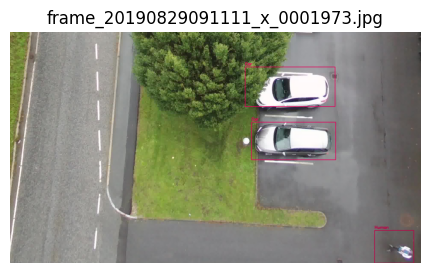

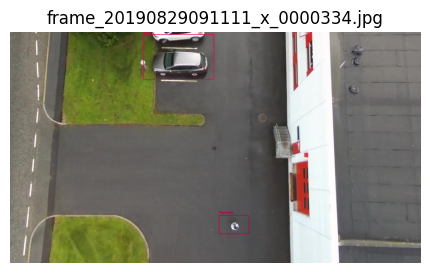

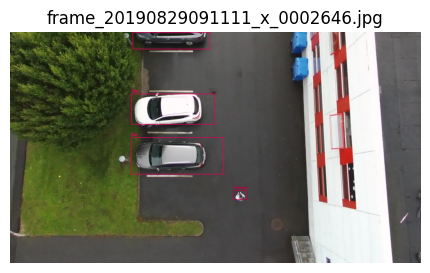

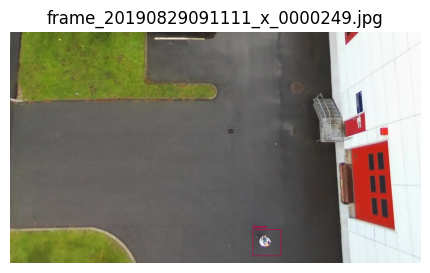

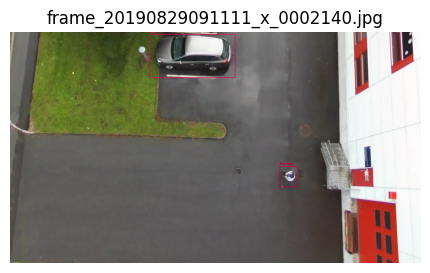

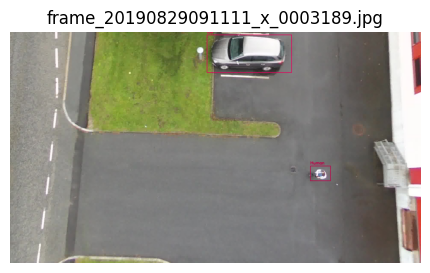

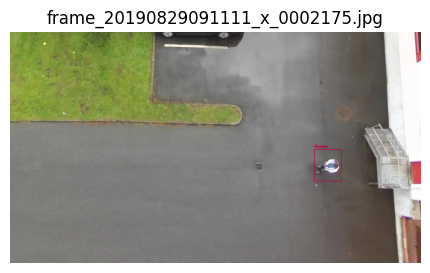

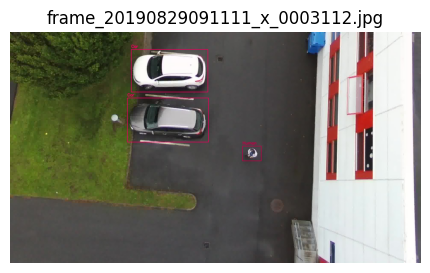

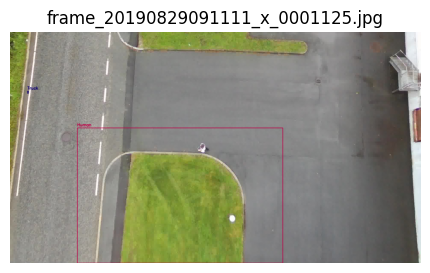

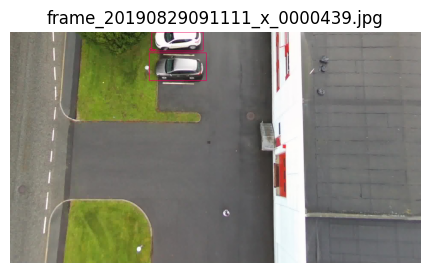

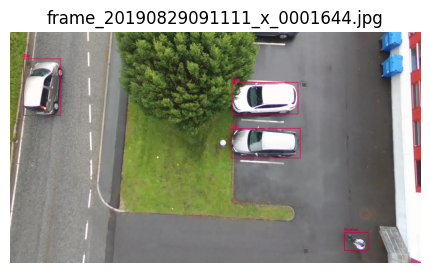

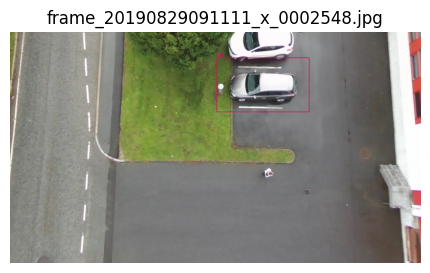

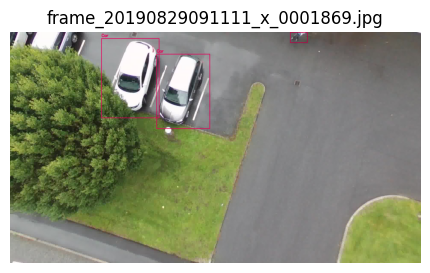

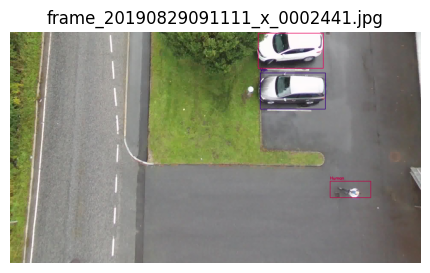

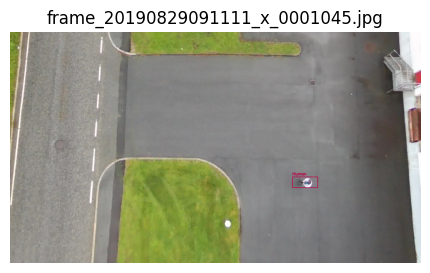

In [4]:
# Visualize formatted and validated annotations
from collections import defaultdict

# Updated file path
VALID_ANNOTATIONS_PATH = "auair2019/annotations_formatted_valid.json"
IMAGES_DIR = "auair2019/images"

# Load annotations
def load_annotations(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)

    img_id_to_file = {img["id"]: img["file_name"] for img in data["images"]}
    ann_by_image = defaultdict(list)
    for ann in data["annotations"]:
        ann_by_image[ann["image_id"]].append(ann)

    return img_id_to_file, ann_by_image

# Draw bounding boxes on image
def bbox_draw(image_path, annotations):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not read image: {image_path}")

    for ann in annotations:
        x, y, w, h = map(int, ann["bbox"])
        class_id = ann["category_id"]
        label = CATEGORY_NAMES[class_id - 1] if 1 <= class_id <= len(CATEGORY_NAMES) else "Unknown"
        color = COLOR_MAP.get(class_id, (0, 255, 0))

        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        cv2.putText(image, label, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Visualize boxes
def visualize_boxes(json_path, images_dir, max_images=5):
    img_id_to_file, ann_by_image = load_annotations(json_path)
    count = 0

    for img_id, filename in img_id_to_file.items():
        if count >= max_images:
            break

        image_path = os.path.join(images_dir, filename)
        if not os.path.exists(image_path):
            print(f"Missing image: {image_path}")
            continue

        annotations = ann_by_image[img_id]
        image = bbox_draw(image_path, annotations)

        plt.figure(figsize=(6, 3))
        plt.imshow(image)
        plt.title(filename)
        plt.axis("off")
        plt.show()

        count += 1

visualize_boxes(VALID_ANNOTATIONS_PATH, IMAGES_DIR, max_images=15)

In [5]:
# Validation for correct Coco format

def validate_coco_json(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Check keys
    required_keys = ['images', 'annotations', 'categories']
    for key in required_keys:
        if key not in data:
            raise ValueError(f"Missing key: '{key}' in COCO JSON file")

    # Validate images
    for img in data['images']:
        if not all(k in img for k in ['id', 'file_name', 'width', 'height']):
            raise ValueError(f"Missing fields in image entry: {img}")

    # Validate annotations
    for ann in data['annotations']:
        if not all(k in ann for k in ['id', 'image_id', 'category_id', 'bbox', 'iscrowd']):
            raise ValueError(f"Missing fields in annotation: {ann}")
        if len(ann['bbox']) != 4:
            raise ValueError(f"Invalid bbox format in annotation: {ann}")

    # Validate categories
    for cat in data['categories']:
        if not all(k in cat for k in ['id', 'name']):
            raise ValueError(f"Missing fields in category: {cat}")

    print("COCO format is valid")

validate_coco_json("auair2019/annotations_formatted_valid.json")

COCO format is valid


In [6]:
# Category checking
with open("auair2019/annotations_formatted_valid.json", "r") as f:
    data = json.load(f)

categories = data.get("categories", [])

print("Category IDs and names:")
for cat in categories:
    print(f"ID: {cat['id']}, Name: {cat['name']}")


Category IDs and names:
ID: 1, Name: human
ID: 2, Name: car
ID: 3, Name: truck
ID: 4, Name: van
ID: 5, Name: motorbike
ID: 6, Name: bicycle
ID: 7, Name: bus
ID: 8, Name: trailer


In [7]:
# Check whether annotations refer to missing images
def check_missing_images(annotation_file, image_dir):
    # Load annotations
    with open(annotation_file, "r") as f:
        data = json.load(f)
    
    missing_images = []

    for image_info in data.get("images", []):
        image_filename = image_info.get("file_name", "")
        
        image_path = os.path.join(image_dir, image_filename)
        
        if not os.path.isfile(image_path):
            missing_images.append(image_filename)
    
    if missing_images:
        print(f"Found {len(missing_images)} missing images:")
        for img in missing_images:
            print(f" - {img}")
    else:
        print("All images referenced in the annotations are found")

if __name__ == "__main__":
    check_missing_images(VALID_ANNOTATIONS_PATH, IMAGES_DIR)

All images referenced in the annotations are found
